# CMIP6 Future Predictions IPCC SSP1-2.6

## General python imports

In [11]:
# general python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import geopandas as gpd
import pandas as pd
import seaborn as sns

#niceties
from rich import print

# Needed
from ipywidgets import IntProgress
from IPython.display import display
from scipy.stats import qmc

In [12]:
# general eWaterCycle
import ewatercycle
import ewatercycle.models
import ewatercycle.forcing

## Defining the experiment and file paths

In [13]:
# Defining the data period
start_calibration = '1986-11-01'
end_calibration = '2012-10-31'

start_validation = '2012-11-01'
end_validation = '2014-10-31'

future_data_start = '2026-11-01'
future_data_end = '2099-10-31' 

start_hydro_year = 1986
end_hydro_year =2014

start_future_hydro_year = 2027
end_future_hydro_year = 2099

In [14]:
# defining path for catchment shape file
km_shp = Path.home() / "BEP-Zoe/book/thesis_projects/BSc/2025_Q4_ZoeLucius_CEG" /  "km_ERA5" / "km.shp"

# defining destination path for CMIP data
CMIP_folder = Path.home() / "CMIP"
CMIP_folder.mkdir(exist_ok=True)

# model HBV destination path
HBV_model_path = Path.home() / "HBV_model" / "CMIP"
HBV_model_path.mkdir(exist_ok=True)

## Importing the observed data

In [15]:
# The HBV model returns values in mm/day so in order to compare this to the observed data it must b converted to m^3/s
catchment_area_km2 = 334882.8

def mmday_to_m3s(Q_sim_mmday, area_km2):
    return (Q_sim_mmday * area_km2) / 86.4

In [16]:
# Loading in discharge data from Katima Mulilo
katima = (pd.read_csv('Katima_Mulilo/1291100_Q_Day.txt', skiprows=35, delimiter=';', header=1)
          .drop(columns=['hh:mm'])
          .rename(columns={"YYYY-MM-DD": "Date", " Value": "Discharge [m^3/s]"}))

# Creating a dataframe with accessible dates and no invalid data 
katima['Date'] = pd.to_datetime(katima['Date'])
katima['Discharge [m^3/s]'] = katima['Discharge [m^3/s]'].replace(-999.000, np.nan)

# Reducing the dataframe to the calibration period
km = katima[(katima['Date'] >= start_calibration) & (katima['Date'] <= end_validation)]

# Creating a dataframe of the flow data 
flow = pd.DataFrame(data=km['Discharge [m^3/s]'].values, index=km['Date'], columns=['Q'])

## Importing the critical inflow per year

In [17]:
Q_crit = (pd.read_csv('Katima_Mulilo/critical_inflow.csv', usecols=[0, 3, 4, 6], delimiter=';', decimal='.')
          .rename(columns={'Year': 'hydro_year', 'Annual Power demand Zambia [MW]': 'power_demand_zambia [MW]', 'Annual Power demand Zimbabwe [MW]': 'power_demand_zimbabwe [MW]', 
                           'Required inflow at Katima Mulilo [m^3/s]': 'Q_crit'}))
Q_crit = Q_crit[(Q_crit['hydro_year'] >= start_future_hydro_year) & (Q_crit['hydro_year'] <= end_future_hydro_year)]

## Importing the drought analyser function

In [18]:
from Drought_Function import analyse_annual_deficits_MW

## Generating the forcings

In [19]:
CMIP_dataset = {'project': 'CMIP6', 'activity': 'ScenarioMIP', 'exp': 'ssp126', 'mip': 'day', 'dataset': 'MPI-ESM1-2-HR', 'ensemble': 'r1i1p1f1', 'institute': 'DKRZ', 'grid': 'gn'}

# CMIP_forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"].generate(
#     dataset=CMIP_dataset,
#     start_time=future_data_start+'T00:00:00Z',
#     end_time=future_data_end+'T00:00:00Z',
#     shape=km_shp,
#     directory=CMIP_folder / 'scen_126')
   
CMIP_126 = CMIP_folder / "scen_126" / "work" / "diagnostic" / "script" 
SSP126 = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(directory=CMIP_126)

## Running the HBV model (with CMIP6 data)

In [20]:
# Applying the parameters found in the KGE model fit calibration
params_KGE = [5.65179127, 0.27593564, 779.15056566, 2.45298864, 0.04682875, 1.3263829, 0.01356608, 0.0070803, 0.48990002]

# Define the initial state parameters (Si,  Su, Sf, Ss, Sp)
s_0 = np.array([0,  100,  0,  5,  0])

In [21]:
model = ewatercycle.models.HBV(forcing=SSP126)

In [22]:
config_file, _ = model.setup(parameters=params_KGE, initial_storage=s_0, cfg_dir = HBV_model_path)

In [23]:
model.initialize(config_file)

In [24]:
Q_m = []
time = []

while model.time < model.end_time:
    model.update()
    Q_m.append(model.get_value("Q")[0])
    time.append(pd.Timestamp(model.time_as_datetime))

In [25]:
model.finalize()

## Visualising the data

In [26]:
CMIP_126_output = pd.DataFrame(data=Q_m, index=time, columns=['Q'])
CMIP_126_output = mmday_to_m3s(CMIP_126_output, catchment_area_km2)

In [27]:
QCMIP_126_sim = CMIP_126_output[future_data_start : future_data_end]
QCMIP_126_obs = flow[start_calibration : end_validation]

QCMIP_126_sim.index = QCMIP_126_sim.index.normalize()
QCMIP_126_obs.index = QCMIP_126_obs.index.normalize()

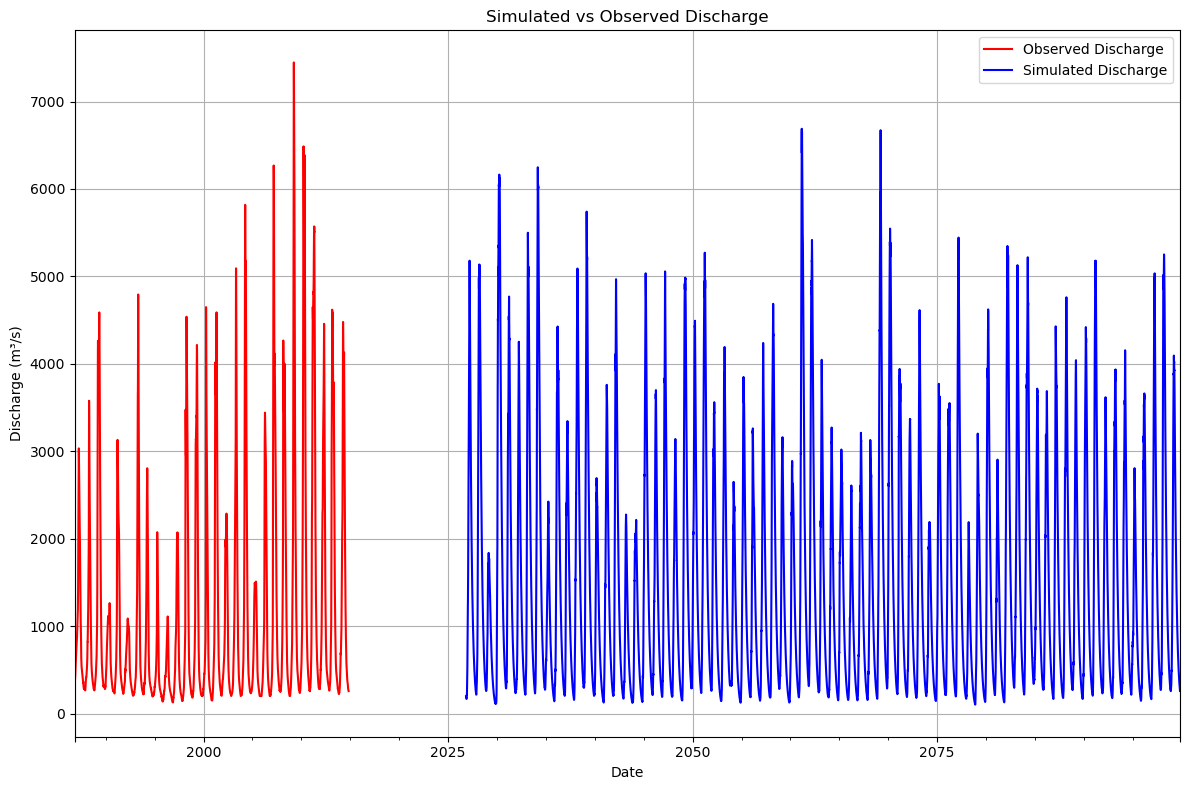

In [28]:
# plot
plt.figure(figsize=(12, 8))

QCMIP_126_obs['Q'].plot(label="Observed Discharge", color='red')
QCMIP_126_sim['Q'].plot(label="Simulated Discharge", color='blue')

plt.title('Simulated vs Observed Discharge')
plt.xlabel('Date')
plt.ylabel('Discharge (m³/s)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [36]:
sim_126_droughts = QCMIP_126_sim.reset_index()
sim_126_droughts.rename(columns={'index': 'Date'}, inplace=True)

sim_126_droughts['Date'] = pd.to_datetime(sim_126_droughts['Date'])
sim_126_droughts['Year'] = sim_126_droughts['Date'].dt.year
sim_126_droughts['Day'] = sim_126_droughts['Date'].dt.dayofyear
sim_126_droughts['hydro_year'] = np.where(sim_126_droughts['Day'] < 305, sim_126_droughts['Year'], sim_126_droughts['Year'] + 1)

analyse_annual_deficits_MW(sim_126_droughts, 'Q', Q_crit, 'hydro_year', 'Q_crit', 'power_demand_zambia [MW]', 'power_demand_zimbabwe [MW]')


,hydro_year,avg_net_deficit_m^3/s,power_shortage_MW,Zambia_shortage_%,Zimbabwe_shortage_%
0,2029,890.01,868.30,50.81,50.60
1,2031,13.43,13.10,0.73,0.73
2,2032,350.09,341.55,18.57,18.80
3,2035,969.45,945.80,47.95,49.28
4,2036,190.51,185.87,9.21,9.51
...,...,...,...,...,...
63,2095,2339.38,2282.31,51.95,70.66
64,2096,1981.84,1933.49,43.75,59.77
65,2097,1620.23,1580.70,35.56,48.80
66,2098,1389.66,1355.76,30.34,41.80
